In [155]:
import os
import json
import json
import nltk
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from module.utils import get_project_root
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from typing import List
from rich import print


In [156]:
root_path = os.path.join(get_project_root(), 'data', 'bbc')
text_path = os.path.join(root_path, 'raw_text')

class_id_map = {
    'business': 0,
    'entertainment': 1,
    'politics': 2,
    'sport': 3,
    'tech': 4
}
df_dict = {
    'class': [],
    'text': [],
    'classid' : [], 
    'title': [],
    'filename': []
}
def gaussian_pdf(x, variance:np.float128, mean=0):
    if not isinstance(x, np.float128) or not isinstance(variance, np.float128) or not isinstance(mean, np.float128):
        x = np.float128(x)
        variance = np.float128(variance)
        mean = np.float128(mean)
    return np.float128((1 / np.sqrt(2 * np.pi * variance)) * np.exp(-0.5 * ((x - mean) ** 2) / (variance+0.00001)))

# Load the data into dataframe
for _class in class_id_map.keys():
    _path = os.path.join(text_path, _class)
    text_list = os.listdir(_path)
    for _text in text_list:
        with open(os.path.join(_path, _text), 'r') as f:
            text = f.read()
        title = text.split('\n')[0]
        text = text.replace(title, '')
        df_dict['class'].append(_class)
        df_dict['text'].append(text)
        df_dict['classid'].append(class_id_map[_class])
        df_dict['title'].append(title)
        df_dict['filename'].append(_text)

df = pd.DataFrame(df_dict)
df.head()
    

,class,text,classid,title,filename
0,business,\n\nUK house prices dipped slightly in Novembe...,0,UK house prices dip in November,415.txt
1,business,\n\nShares in struggling German football club ...,0,Rescue hope for Borussia Dortmund,219.txt
2,business,\n\nIndia's rupee has hit a five-year high aft...,0,India's rupee hits five-year high,018.txt
3,business,\n\nTurkey's investment in Iran's mobile indus...,0,Turkey-Iran mobile deal 'at risk',074.txt
4,business,\n\nTelecoms equipment maker Nortel Networks h...,0,Nortel in $300m profit revision,425.txt


In [157]:
len(df)

2225

In [158]:
def clean_and_split_words(text: str, use_stemming: bool = False) -> list:
    """
    Clean and split words from text.
    - Converts text to lowercase.
    - Removes special characters and numbers.
    - Removes stopwords.
    - Optionally applies stemming.
    """
    text = re.sub(r'[^a-zA-Z\s]', ' ', text.lower())
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word.strip() for word in words if word not in stop_words]
    if use_stemming:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]
    return words

def generate_ngrams(words, ngram_range):
    ngrams_list = []
    for n in range(ngram_range[0], ngram_range[1] + 1):
        for i in range(len(words) - n + 1):
            ngrams_list.append(' '.join(words[i:i + n]))
    return ngrams_list

class TfIdfVectorizer:
    def __init__(self, sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), stop_word_lang='english'):
        nltk.download('stopwords')
        self.sublinear_tf = sublinear_tf
        self.min_df = min_df
        self.norm = norm
        self.ngram_range = ngram_range
        self.stop_words = stopwords.words(stop_word_lang)
        self.token_map = {}
    
    def fit_transform(self, documents: pd.Series) -> np.ndarray:
        if self.ngram_range == (1,1):
            docs_tokens = [clean_and_split_words(doc) for doc in documents]
        else:
            docs_tokens = [generate_ngrams(clean_and_split_words(doc), self.ngram_range) for doc in documents]
        vocabulary = set(word for doc in docs_tokens for word in doc)
        vocab_index = {word: idx for idx, word in enumerate(vocabulary)}

        df = {word: 0 for word in vocabulary}
        for tokens in docs_tokens:
            unique_tokens = set(tokens)
            for token in unique_tokens:
                df[token] += 1

        total_docs = len(documents)
        idf = {word: np.log(total_docs / (df[word] + 1)) + 1 for word in vocabulary}

        tf = {word: 0 for word in vocabulary}
        for tokens in docs_tokens:
            for token in tokens:
                tf[token] += 1
        
        vocab_index = {word: idx for idx, word in enumerate(vocabulary) if tf[word] >= self.min_df}
        vocabulary = set(vocab_index.keys())

        tfidf_matrix = np.zeros((total_docs, len(vocabulary)))
        for doc_idx, tokens in enumerate(docs_tokens):
            doc_freq = {word: 0 for word in vocab_index.keys()}
            for token in tokens:
                if token in vocab_index:
                    doc_freq[token] += 1
            vector = np.array([doc_freq[word] * idf[word] for word in vocab_index.keys()])
            if self.sublinear_tf:
                vector = np.log(vector + 1)
            tfidf_matrix[doc_idx] = vector

        if self.norm == 'l2':
            norms = np.linalg.norm(tfidf_matrix, axis=1, keepdims=True)
            tfidf_matrix = tfidf_matrix / norms
        elif self.norm == 'l1':
            norms = np.linalg.norm(tfidf_matrix, ord=1, axis=1, keepdims=True)
            tfidf_matrix = tfidf_matrix / norms
        elif self.norm == None:
            pass
        
        self.token_map = vocab_index

        return tfidf_matrix

In [159]:
vectorizer = TfIdfVectorizer(norm=None, ngram_range=(1,2))
texts = df['text']
features = vectorizer.fit_transform(texts)
features.shape
print(features)

[nltk_data] Downloading package stopwords to /home/nemit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

In [160]:
features.shape
vectorizer.token_map

{'load': 59,
 'draw': 89,
 'outlaw': 116,
 'menzies campbell': 123,
 'regard': 142,
 'way said': 166,
 'lie': 180,
 'said far': 244,
 'role helping': 299,
 'bmw': 306,
 'two ronnies': 324,
 'public services': 340,
 'scrum half': 346,
 'tests': 391,
 'lennon': 394,
 'hollywood': 401,
 'andy': 465,
 'told radio': 479,
 'brush': 527,
 'backbencher': 570,
 'channel': 577,
 'tipped win': 685,
 'would done': 687,
 'restaurants': 708,
 'prettejohn': 712,
 'wished': 743,
 'seized': 744,
 'department store': 784,
 'peel': 797,
 'mile': 807,
 'new technologies': 874,
 'computer': 907,
 'ugly': 945,
 'neil': 981,
 'exposed': 988,
 'query': 992,
 'evidence': 1061,
 'telekom': 1095,
 'resist': 1097,
 'jeff': 1123,
 'mubanga said': 1130,
 'going really': 1172,
 'mogul': 1174,
 'newspaper reports': 1178,
 'brain': 1180,
 'time high': 1184,
 'eurosceptic party': 1188,
 'ipods mp': 1202,
 'speak': 1233,
 'started': 1235,
 'peace': 1270,
 'ill fated': 1354,
 'area networks': 1361,
 'sms': 1369,
 'teeth'

In [161]:
from sklearn.feature_selection import chi2

N = 5
for category, category_id in sorted(class_id_map.items()):
    features_chi2 = chi2(features, df['classid'] == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(list(vectorizer.token_map.keys()))[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'business':

. Most correlated unigrams:
       . bank
       . oil
       . growth
       . shares
       . bn

. Most correlated bigrams:
       . oil prices
       . economic growth
       . stock market
       . analysts said
       . bn bn

# 'entertainment':

. Most correlated unigrams:
       . singer
       . award
       . actor
       . awards
       . film

. Most correlated bigrams:
       . named best
       . million dollar
       . best film
       . los angeles
       . box office

# 'politics':

. Most correlated unigrams:
       . tory
       . party
       . blair
       . election
       . labour

. Most correlated bigrams:
       . michael howard
       . general election
       . prime minister
       . tony blair
       . mr blair

# 'sport':

. Most correlated unigrams:
       . win
       . injury
       . match
       . coach
       . cup

. Most correlated bigrams:
       . champions league
       . bbc sport
       . year old
       . grand slam
       . six nations

# 'tech':

. Most correlated unigrams:
       . digital
       . computer
       . software
       . technology
       . users

. Most correlated bigrams:
       . high definition
       . mobile phones
       . mobile phone
       . news website
       . e mail

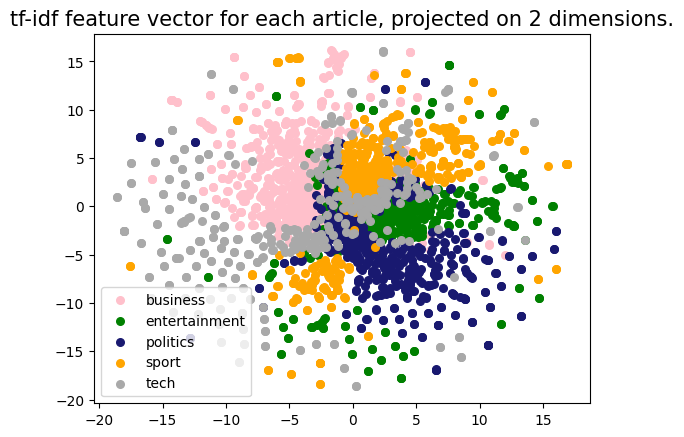

In [162]:
from sklearn.manifold import TSNE

SAMPLE_SIZE = int(len(features))
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
for category, category_id in sorted(class_id_map.items()):
    points = projected_features[(df.classid[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

In [163]:
df['embedding']=list(features)

In [164]:
df.set_index('filename', inplace=True)
df.head()

,class,text,classid,title,embedding
filename,,,,,
415.txt,business,\n\nUK house prices dipped slightly in Novembe...,0,UK house prices dip in November,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
219.txt,business,\n\nShares in struggling German football club ...,0,Rescue hope for Borussia Dortmund,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
018.txt,business,\n\nIndia's rupee has hit a five-year high aft...,0,India's rupee hits five-year high,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
074.txt,business,\n\nTurkey's investment in Iran's mobile indus...,0,Turkey-Iran mobile deal 'at risk',"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
425.txt,business,\n\nTelecoms equipment maker Nortel Networks h...,0,Nortel in $300m profit revision,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [165]:
# Start calculating centroind and variance from test dataset
if isinstance(df.iloc[0]['embedding'], list):
    df['embedding'] = df['embedding'].apply(lambda x: np.array(x, dtype=np.float128))

train_test_ratio = 0.7
train_size = int(len(df) * train_test_ratio)
# Shuffle dataset
df = df.sample(frac=1)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

centroid_df = train_df.groupby('classid')['embedding'].apply(lambda x: np.mean(np.stack(x), axis=0)).reset_index()

centroid_df['embedding'] = centroid_df['embedding'].apply(lambda x: np.array(x, dtype=np.float128))

centroid_df.columns = ['classid', 'centroid']

centroid_df.head()

,classid,centroid
0,0,"[0.009567258650722172686, 0.033088098007264053..."
1,1,"[0.01289227313261250181, 0.0111468920335946949..."
2,2,"[0.011808238154494934621, 0.035733655392979984..."
3,3,"[0.0, 0.15227987983290089402, 0.0, 0.0, 0.0, 0..."
4,4,"[0.026515187491250237495, 0.031873144408559830..."


In [166]:
df_test = df.copy()

df['distance_to_centroid_0'] = df['embedding'].apply(lambda x: np.float128(np.linalg.norm(x - centroid_df.loc[0]['centroid'])))
df['distance_to_centroid_1'] = df['embedding'].apply(lambda x: np.float128(np.linalg.norm(x - centroid_df.loc[1]['centroid'])))
df['distance_to_centroid_2'] = df['embedding'].apply(lambda x: np.float128(np.linalg.norm(x - centroid_df.loc[2]['centroid'])))
df['distance_to_centroid_3'] = df['embedding'].apply(lambda x: np.float128(np.linalg.norm(x - centroid_df.loc[3]['centroid'])))
df['distance_to_centroid_4'] = df['embedding'].apply(lambda x: np.float128(np.linalg.norm(x - centroid_df.loc[4]['centroid'])))


train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

df.head()


,class,text,classid,title,embedding,distance_to_centroid_0,distance_to_centroid_1,distance_to_centroid_2,distance_to_centroid_3,distance_to_centroid_4
filename,,,,,,,,,,
198.txt,tech,\n\nAnalyst Bill Thompson has seen the future ...,4,Musical future for phones,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",36.150746,36.056102,36.122372,36.103184,34.295932
085.txt,entertainment,\n\nRoman Catholic organisations in India have...,1,Church anger over Bollywood film,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22.901564,22.479282,22.902032,23.062860,23.102874
363.txt,business,"\n\nAlbania, Bulgaria and Macedonia has given ...",0,Go-ahead for Balkan oil pipeline,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",19.126090,19.613763,19.858996,19.694255,20.064475
354.txt,entertainment,\n\nHollywood stars brought a touch of glamour...,1,Stars shine on Bafta red carpet,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",31.231711,29.763306,31.251330,30.901229,31.154295
135.txt,entertainment,\n\nThe US Vibe awards will be held again next...,1,Vibe awards back despite violence,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18.735009,18.224808,19.196691,18.831762,19.370019


In [167]:
for i in range(5):
    # Filter df for the current category
    category_mask = train_df['classid'] == i
    
    # Calculate variance of 'distance_to_centroid_i' for this category
    variance = np.var(train_df.loc[category_mask, f"distance_to_centroid_{i}"])
    
    # Assign calculated variance to the correct entry in centroid_df
    centroid_df.loc[centroid_df['classid'] == i, 'variance'] = np.var(train_df.loc[category_mask, f"distance_to_centroid_{i}"])

centroid_df.head()

,classid,centroid,variance
0,0,"[0.009567258650722172686, 0.033088098007264053...",16.962785
1,1,"[0.01289227313261250181, 0.0111468920335946949...",27.489168
2,2,"[0.011808238154494934621, 0.035733655392979984...",29.440864
3,3,"[0.0, 0.15227987983290089402, 0.0, 0.0, 0.0, 0...",29.114598
4,4,"[0.026515187491250237495, 0.031873144408559830...",22.808816


In [168]:
df['pmf_cat0'] = df['distance_to_centroid_0'].apply(lambda x: float(gaussian_pdf(x, centroid_df.iloc[0]['variance'])))
df['pmf_cat1'] = df['distance_to_centroid_1'].apply(lambda x: float(gaussian_pdf(x, centroid_df.iloc[1]['variance'])))
df['pmf_cat2'] = df['distance_to_centroid_2'].apply(lambda x: float(gaussian_pdf(x, centroid_df.iloc[2]['variance'])))
df['pmf_cat3'] = df['distance_to_centroid_3'].apply(lambda x: float(gaussian_pdf(x, centroid_df.iloc[3]['variance'])))
df['pmf_cat4'] = df['distance_to_centroid_4'].apply(lambda x: float(gaussian_pdf(x, centroid_df.iloc[4]['variance'])))

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]


In [169]:
df.head()
df.to_csv('./test.csv')

In [171]:
data = df.copy()
distance_cols = [col for col in data.columns if "distance_to_centroid_" in col]
pmf_cols = [col for col in data.columns if "pmf_cat" in col]

# Task 1: Finding the closest centroid
data['closest_centroid'] = data[distance_cols].idxmin(axis=1).str.extract('(\d+)').astype(int)

# Task 2: Finding the PMF category with the highest probability
data['pmf_predict'] = data[pmf_cols].idxmax(axis=1).str.extract('(\d+)').astype(int)

# Task 3: Comparison Columns
data['distance_correct'] = (data['closest_centroid'] == data['classid']).astype(int)
data['pmf_correct'] = (data['pmf_predict'] == data['classid']).astype(int)

# Displaying the updated DataFrame with the new columns
data[['classid', 'closest_centroid', 'pmf_predict', 'distance_correct', 'pmf_correct']].head()

,classid,closest_centroid,pmf_predict,distance_correct,pmf_correct
filename,,,,,
198.txt,4,4,2,1,0
085.txt,1,1,2,1,0
363.txt,0,0,3,1,0
354.txt,1,1,1,1,1
135.txt,1,1,1,1,1


In [173]:
distance_accuracy = data['distance_correct'].mean()
pmf_col_accuracy = data['pmf_correct'].mean()
print(f"Accuracy of distance-based classification: {distance_accuracy:.2f}")
print(f"Accuracy of PMF-based classification: {pmf_col_accuracy:.2f}")

Accuracy of distance-based classification: 0.96

Accuracy of PMF-based classification: 0.52